In [1]:
import openturns as ot
import numpy as np
import matplotlib as mpl

# Implementation of AK-MCS

## Sources :  
* Echard, B., Gayton, N., & Lemaire, M. (2011). AK-MCS: an active learning reliability method combining Kriging and Monte Carlo simulation. Structural Safety, 33(2), 145-154.
* B. Echard Phd thesis

This notebook implements the AK- MCS method which couples Gaussian Process based surrogate model and Crude Monte Carlo algorithm.


In case of rare event probability estimation, the surrogate model has to be accurate in the zones that are relevant to the failure probability estimation i.e. in the vicinity of failure threshold $T$ and in the high probability content regions. The use of the exact function $\phi$ and its surrogate $\hat{\phi}$ in the probability calculation will lead to the same result if $\forall \mathbf{x} \in \mathbb{R}^d, \mathbf{1}_{\phi(\mathbf{x})>T} = \mathbf{1}_{\hat{\phi}(\mathbf{x},\mathcal{X})>T}$. In other words, the surrogate model might not be representative of the exact function outside the zones of interest as it does not take part of the probability estimation. From the initial training set $\mathcal{X}$, the Gaussian process properties (i.e. estimation of the predicted error variance) are  valuable to determine the additional samples which have to be evaluated on $\phi(\cdot)$ to refine its surrogate model. Different refinement strategies have been developed in the literature. Here, the method described in [Echard 2011] is implemented  ("U criterion").


This method determines a new sample point $\mathbf{x}$ to add to the training set $\mathcal{X}$ by solving the following optimisation problem:
\begin{equation}
\underset{\mathbf{x}}{\max}  \left[1 - \Phi_{0,1}\left( \frac{|T-\hat{\phi}(\mathbf{x},\mathcal{X})|}{\hat{\sigma}(\mathbf{x},\mathcal{X})}\right)\right], \label{eq:echard}
\end{equation}
where $\Phi_{0,1}(\cdot)$ is the cdf of the standard Gaussian distribution, $\hat{\phi}$ the mean prediction of the Kriging and $\hat{\sigma}$ the estimated standard deviation of the prediction error. The used criterion generates a sample for which the Kriging prediction is closed to the threshold  (numerator) and which presents a high prediction error (denominator). Due to the monotonicity of the involved cdf, the optimisation problem is equivalent to:
\begin{equation}
\underset{\mathbf{x}}{\min}\;  \frac{|T-\hat{\phi}(\mathbf{x},\mathcal{X})|}{\hat{\sigma}(\mathbf{x},\mathcal{X})}. \label{eq:echard2}
\end{equation}
This criterion has been coupled with CMC. In practice, the optimisation problem is not solved, and given a sample set $\{\mathbf{X}_1,\dots, \mathbf{X}_N\}$ provided by CMC the new sample which will be added to the training set is determined by
\begin{equation*}
\mathbf{X} = \underset{\mathbf{X}_1,\dots,\mathbf{X}_N}{\text{argmin}}  \left\{\frac{|T-\hat{\phi}(\mathbf{X}_1,\mathcal{X})|}{\hat{\sigma}(\mathbf{X}_1,\mathcal{X})},\dots, \frac{|T-\hat{\phi}(\mathbf{X}_N,\mathcal{X})|}{\hat{\sigma}(\mathbf{X}_N,\mathcal{X})}     \right\}.
\end{equation*}


In this notebook, this criterion is implemented with MCS simulation. The "double loop" that controls the coefficient of variation is not implemented in this notebook. The accuracy of the algorithm is driven by the number of samples in the Monte Carlo experiment.

## Definition of algorithm AK-MCS  class (implemented here with "U" criterion, see sources)

In [2]:
		
class AK_MCSAlgorithm(object):
    """
    Class implementing AK MCS algorithm
	 
    :event: ThresholdEvent based on composite vector of input variables on limit state function 
    
    :n_MC: integer, number of MCS samples
    
    :n_DoE: integer, number of samples in initial Kriging DoE
    
    :sim_budget: integer, total simulation budget available
    
    :basis: basis of kriging model
    
    :cov_model: covariance model of kriging
        
    :u_criterion: float, threshold value for `u criterion`
    
    :verbose: verbosity parameter 
        
    """
    
    def __init__(self,event,n_MC,n_DoE,sim_budget,basis, cov_model,u_criterion = 2,verbose = False):
        self.n_MC = n_MC
        self.n_DoE = n_DoE
        self.limit_state_function = event.getFunction()
        self.S = event.getThreshold()
        self.basis = basis
        self.cov_model = cov_model
        self.dim = event.getAntecedent().getDimension()
        self.proba = 0.
        self.distrib = event.getAntecedent().getDistribution()
        self.nb_eval = 0
        self.cv = None
        self.max_sim = sim_budget
        self.U_criterion = u_criterion 
        self.DoE = None
        self.kriging_model = None
        self.verbose = verbose
        self.samples = None
        self.operator = event.getOperator()
        self.event = event
        
    #Function determining the U criterion of AK -MCS
    def compute_U(self,my_krig,list_id_evaluated):
        """
        Function computing the infill criterion
        
        :my_krig: Kriging models, :py:class:`openturns.KrigingResult`
        
        :list_id_evaluated: list of evaluated :py:class:`openturns.Sample`
        """
        y_pred = my_krig.getConditionalMean(self.samples)
        y_var_pred = my_krig.getConditionalMarginalVariance(self.samples)
        
        list_id_non_evaluated = np.setdiff1d(np.arange(self.n_MC),list_id_evaluated)
        U = np.zeros((self.n_MC,1))
        
        U[list_id_non_evaluated] = np.abs(ot.Sample([ot.Point([self.S])]*int(len(list_id_non_evaluated)))-y_pred[list_id_non_evaluated])/np.sqrt(y_var_pred[list_id_non_evaluated])
        
        if len(list_id_evaluated)>0:
            U[list_id_evaluated] = 5e5
        return U

    #Function computing the probability of failure
    def compute_proba(self):
        """
        Function computing failure probability using AK-IS
        
        
        """
        #Generation of experiment
        ot.RandomGenerator.SetSeed(1)
        myExperiment = ot.MonteCarloExperiment(self.distrib, self.n_MC)
        self.samples = myExperiment.generate()
        
        #Generation of DoE
        DoE_inputs = self.samples[0:self.n_DoE]
        # Calculation of True function of the DoE
        DoE_responses = self.limit_state_function(DoE_inputs)
        
        list_id_samples_evaluated = np.linspace(0,self.n_DoE-1,self.n_DoE,dtype = int).tolist()
        #Definition of Kriging algorithm
        algokriging = ot.KrigingAlgorithm(DoE_inputs, 
                                          DoE_responses,
                                          self.cov_model,
                                          self.basis)

        algokriging.run()
        my_krig = algokriging.getResult()
        updated_cov = my_krig.getCovarianceModel()
        U_y_pred = self.compute_U(my_krig,list_id_samples_evaluated)
        id_opt_U=np.argmin(U_y_pred)
        current_min_U = np.min(U_y_pred)
        nb_pt_sim = 0
        list_id_samples_evaluated.append(id_opt_U)
        
        while nb_pt_sim<self.max_sim and current_min_U < self.U_criterion:
                #evaluation of true function
                x_new = self.samples[int(id_opt_U)]
                y_new = self.limit_state_function(x_new)

                DoE_inputs.add(x_new)
                DoE_responses.add(y_new)
                
                
                # Definition of Kriging model
                startingPoint =updated_cov.getScale()
                algokriging = ot.KrigingAlgorithm(DoE_inputs, 
                                                  DoE_responses,
                                                  updated_cov,
                                                  self.basis)
                
                
                solver_kriging = ot.NLopt('GN_DIRECT')
                solver_kriging.setStartingPoint(startingPoint)
                algokriging.setOptimizationAlgorithm(solver_kriging)
                algokriging.setOptimizationBounds(ot.Interval([0.01]*self.dim, [100]*self.dim))
                algokriging.run()
                my_krig = algokriging.getResult()
                updated_cov = my_krig.getCovarianceModel()

                # computation of U

                U_y_pred = self.compute_U(my_krig,list_id_samples_evaluated)
                current_min_U=np.min(U_y_pred)
                id_opt_U = np.argmin(U_y_pred)         
                nb_pt_sim = nb_pt_sim+1
                list_id_samples_evaluated.append(id_opt_U)
                

                y = my_krig.getConditionalMean(self.samples)
                I = [self.operator(y[i][0],self.S) for i in range(self.n_MC)]
                int_I = [int(i) for i in I]

                Pf = 1/self.n_MC*np.sum(np.array(int_I))
                
                self.cv = np.sqrt((1-Pf)/(self.n_MC*Pf))

                self.proba = Pf
                self.nb_eval = self.n_DoE+nb_pt_sim
                self.DoE = [DoE_inputs,DoE_responses]
                self.kriging_model = my_krig
        
                if self.verbose == True:
                    if nb_pt_sim == 1:
                        print('current_min_U', '| Nb_sim',' | Probability estimate', ' | Coefficient of variation')
                        print('{:9e}'.format(current_min_U),' | ','{:5d}'.format(int(nb_pt_sim)),' |      ','{:11e}'.format(Pf),'   |      ','{:11e}'.format(self.cv))

                    else:
                        print('{:9e}'.format(current_min_U),' | ','{:5d}'.format(int(nb_pt_sim)),' |      ','{:11e}'.format(Pf),'   |      ','{:11e}'.format(self.cv))
               
            
        return 
                   
    #Accessor to the number of evaluated samples             
    def getSimBudget(self):      
        """
        Accessor to the simulation budget
        
        """      
        return self.nb_eval
    
    #Accessor to the kriging model 
    def getKrigingModel(self):
        """
        Accessor to the Kriging model,  :py:class:`openturns.KrigingResult` 
        
        """       
        return self.kriging_model
                   
    #Accessor to the DoE
    def getDoE(self):
        """
        Accessor to the Design of Experiments, :py:class:`openturns.Sample`
        
        """
        return self.DoE
    
    #Accessor to the failure probability
    def getFailureProbability(self):
        """
        Accessor to the computed failure probability
        
        """
        return self.proba
    
    #Accessor to the failure probability
    def getCoefficientOfVariation(self):
        """
        Accessor to Coefficient of Variation 
        
        """
        return self.cv        
    
    #Accessor to the MonteCarlo samples
    def getMonteCarloSamples(self):
        """
        Accessor to Monte-Carlo samples,  :py:class:`openturns.Samples`
        
        """
        return self.samples

## Numerical experiments

## Experiment 1 : "four branch function"

$$G(x_1,x_2) = min \begin{pmatrix}3+0.1(x_1-x_2)^2-\frac{(x_1+x_2)}{\sqrt{2}};\\3+0.1(x_1-x_2)^2+\frac{(x_1+x_2)}{\sqrt{2}};\\
(x_1-x_2)+ \frac{k}{\sqrt{2}};\\
(x_2-x_1)+ \frac{k}{\sqrt{2}}
\end{pmatrix}$$

with : 
* $k$ is equal to 6 or 7
* $x_1 \sim \mathcal{N}(0,1)$
* $x_2 \sim \mathcal{N}(0,1)$


### Definition of input variable probability distributions

In [3]:
dim_inputs = 2
dist_x = ot.Normal([0.0, 0.0], [1., 1.], ot.CorrelationMatrix(dim_inputs))
inputVector = ot.RandomVector(dist_x)

### Definition of limit state function

In [4]:
#Definition of limit state function
def four_branch(x):
    x1 = x[0]
    x2  = x[1]
    k = x[2]
    g1 = 3+0.1*(x1-x2)**2-(x1+x2)/np.sqrt(2)
    g2 = 3+0.1*(x1-x2)**2+(x1+x2)/np.sqrt(2)
    g3 = (x1-x2)+k/np.sqrt(2)
    g4 =(x2-x1)+k/np.sqrt(2)
    return [min((g1,g2,g3,g4))]

# Definition of python function
my_four_branch = ot.PythonFunction(3, 1, four_branch)

# Transformation of python function to parametric function
index_frozen = [2]
my_four_branch_6 = ot.ParametricFunction(my_four_branch, index_frozen, [6])
my_four_branch_7 = ot.ParametricFunction(my_four_branch, index_frozen, [7])

# Definition of event
Y = ot.CompositeRandomVector(my_four_branch_6, inputVector)
my_event4b = ot.ThresholdEvent(Y,ot.Less(),0.0)

### Estimation of reference probability

In [5]:
n_MC = np.int(1e4)

# Creation of event
ot.RandomGenerator.SetSeed(1)

# create a Monte Carlo algorithm
experiment = ot.MonteCarloExperiment()
algo = ot.ProbabilitySimulationAlgorithm(my_event4b, experiment)
algo.setMaximumOuterSampling(int(n_MC))
algo.run()

# retrieve results
result = algo.getResult()
probability = result.getProbabilityEstimate()
print('Failure probability', probability)
print('Coefficient of variation', result.getCoefficientOfVariation())

D:\mbalesde\Logiciels\Externes\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


Failure probability 0.004399999999999991
Coefficient of variation 0.1504236441762826


### Definition of AK-MCS experiment

In [6]:
# Definition of Kriging model
dim_4b = 2
basis = ot.ConstantBasisFactory(dim_4b).build()
covarianceModel = ot.MaternModel(dim_4b)
n_MC_4b = 10000
n_DoE_4b = 20
sim_budget_4b = 200
verbose = True
criterion = 2
my_AK_four_branch = AK_MCSAlgorithm(my_event4b,
                                    n_MC_4b,
                                    n_DoE_4b,
                                    sim_budget_4b,
                                    basis,
                                    covarianceModel,
                                    criterion,
                                    verbose)

### Computation of the failure probability

In [7]:
#computation of probability with AK-MCS
my_AK_four_branch.compute_proba()

current_min_U | Nb_sim  | Probability estimate  | Coefficient of variation
1.241195e-01  |      1  |       1.000000e-03    |       3.160696e-01
4.753913e-03  |      2  |       3.900000e-03    |       1.598156e-01
6.701981e-03  |      3  |       3.200000e-03    |       1.764936e-01
6.113580e-02  |      4  |       3.000000e-03    |       1.823001e-01
8.048600e-02  |      5  |       3.000000e-03    |       1.823001e-01
1.481122e-01  |      6  |       2.700000e-03    |       1.921901e-01
1.490292e-01  |      7  |       2.700000e-03    |       1.921901e-01
1.583539e-01  |      8  |       2.600000e-03    |       1.958610e-01
4.454312e-02  |      9  |       2.400000e-03    |       2.038790e-01
1.326787e-01  |     10  |       2.400000e-03    |       2.038790e-01
1.793139e-01  |     11  |       2.500000e-03    |       1.997498e-01
3.484472e-01  |     12  |       2.500000e-03    |       1.997498e-01
4.628640e-01  |     13  |       2.500000e-03    |       1.997498e-01
2.618786e-02  |     14  |   

 ### Post treatments

In [8]:
print('Probability of failure',my_AK_four_branch.getFailureProbability())
print('Simulation budget',my_AK_four_branch.getSimBudget())
print('Coefficient of variation',my_AK_four_branch.getCoefficientOfVariation())

Probability of failure 0.0044
Simulation budget 61
Coefficient of variation 0.1504236441762821


### Post processing

In [9]:
#Kriging model 
kr = my_AK_four_branch.getKrigingModel()
[DoE_four_branch_x,DoE_four_branch_y]= my_AK_four_branch.getDoE()

D:\mbalesde\Logiciels\Externes\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
D:\mbalesde\Logiciels\Externes\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
D:\mbalesde\Logiciels\Externes\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Eithe

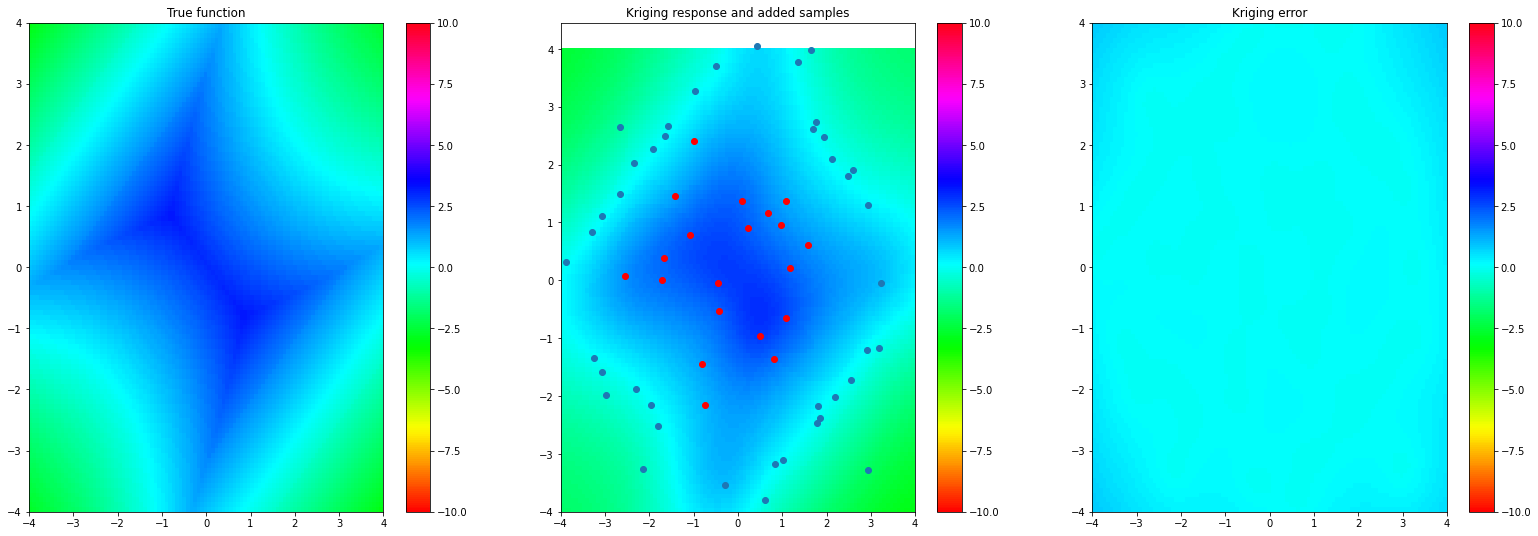

In [10]:
#Plot of surrogate model
import matplotlib.pyplot as plt

grid_size = 100
x1 = np.linspace(-4,4,grid_size)
x2 = np.linspace(-4,4,grid_size)

xx1,xx2 = np.meshgrid(x1,x2)

xx1_ = xx1.reshape((grid_size**2,1))
xx2_ = xx2.reshape((grid_size**2,1))

x = np.concatenate((xx1_,xx2_),1)
                  
y_true = np.array(my_four_branch_7(x))
y_mean_krig =np.array(kr.getConditionalMean(x))     
                   
y_sigma_krig = np.array(np.sqrt(kr.getConditionalMarginalVariance(x)))

y_true = y_true.reshape((grid_size,grid_size))
y_mean_krig = y_mean_krig.reshape((grid_size,grid_size))
y_sigma_krig= y_sigma_krig.reshape((grid_size,grid_size))

cmap = mpl.cm.hsv
norm = mpl.colors.Normalize(vmin=-10, vmax=10)
%matplotlib inline 
fig, (ax0, ax1,ax2) = plt.subplots(ncols=3,figsize=(27,9))
im1 = ax0.pcolormesh(xx1,xx2,y_true,norm = norm,cmap = cmap)
fig.colorbar(im1, ax=ax0)
ax0.title.set_text('True function')

im2 = ax1.pcolormesh(xx1,xx2,y_mean_krig,norm = norm,cmap = cmap)
ax1.scatter(DoE_four_branch_x[0:my_AK_four_branch.n_DoE,0],DoE_four_branch_x[0:my_AK_four_branch.n_DoE,1],color = 'r')
ax1.scatter(DoE_four_branch_x[my_AK_four_branch.n_DoE:,0],DoE_four_branch_x[my_AK_four_branch.n_DoE:,1])
fig.colorbar(im2, ax=ax1)
ax1.title.set_text('Kriging response and added samples')

im3 = ax2.pcolormesh(xx1,xx2,y_sigma_krig,norm = norm,cmap = cmap)
fig.colorbar(im3, ax=ax2)
ax2.title.set_text('Kriging error')

## Experiment 2 : "Non linear oscillator"

$G(c_1,c_2,m,r,t_1,F_1)  = 3r-\left|\frac{2 F_1}{m \omega_0^2}sin\left(\frac{\omega_0 t_1}{2}\right)\right|$

with : 
* $\omega_0 = \sqrt{\left(\frac{c_1+c_2}{m}\right)}$
* $m \sim \mathcal{N}(1,0.05)$
* $c_1 \sim \mathcal{N}(1,0.1)$
* $c_2 \sim \mathcal{N}(0.1,0.01)$
* $r \sim \mathcal{N}(0.5,0.05)$
* $F_1 \sim \mathcal{N}(1.,0.2)$
* $r \sim \mathcal{N}(1.,0.2)$

In [11]:
#Definition of classical function
def non_lin_osc(x):
    c1 = x[0]
    c2  = x[1]
    m = x[2]
    r = x[3]
    t1 = x[4]
    F1= x[5]
    
    omega = np.sqrt((c1+c2)/m)
    
    G = 3*r - np.abs(2*F1/(m*omega**2)*np.sin(omega*t1/2))
    return [G]

# Definition de la pythonfunction generale
non_lin_osc = ot.PythonFunction(6, 1, non_lin_osc)

In [12]:
dist_c1=ot.Normal(1, 0.1)
dist_c2=ot.Normal(0.1, 0.01)
dist_m=ot.Normal(1.,0.05 )
dist_r =ot.Normal(0.5, 0.05)
dist_t1 =ot.Normal(1., 0.2)
dist_F1=ot.Normal(1., 0.2)
std_dev = [dist_c1.getStandardDeviation()[0],dist_c2.getStandardDeviation()[0],dist_m.getStandardDeviation()[0],
           dist_r.getStandardDeviation()[0],dist_t1.getStandardDeviation()[0],dist_F1.getStandardDeviation()[0]]
dim_inputs=6
marginals = [dist_c1,dist_c2,dist_m,dist_r,dist_t1,dist_F1]
dist_x = ot.ComposedDistribution(marginals)

# Creation of event
vect = ot.RandomVector(dist_x)
G = ot.CompositeRandomVector(non_lin_osc, vect)
event_osc = ot.ThresholdEvent(G, ot.Less(), 0.0)

### Estimation of reference probability

In [13]:
n_MC = np.int(1e4)

# create a Monte Carlo algorithm
experiment = ot.MonteCarloExperiment()
algo = ot.ProbabilitySimulationAlgorithm(event_osc, experiment)
algo.setMaximumOuterSampling(int(n_MC))

algo.run()

# retrieve results
result = algo.getResult()
probability = result.getProbabilityEstimate()
print('Failure probability', probability)
print('Coefficient of variation', result.getCoefficientOfVariation())

Failure probability 0.025960264900662253
Coefficient of variation 0.0996954410713017


D:\mbalesde\Logiciels\Externes\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


## Definition of AK MCS experiment

In [14]:
# Definition of Kriging model
dim_osc = 6
basis = ot.ConstantBasisFactory(dim_osc).build()
covarianceModel = ot.SquaredExponential([0.1]*dim_osc, [1.0])
n_MC_osc = 10000
n_DoE_osc = 40
sim_budget_osc = 200
verbose = True

my_AK_non_lin_osc = AK_MCSAlgorithm(event_osc,
                                    n_MC_osc,
                                    n_DoE_osc,
                                    sim_budget_osc,
                                    basis,
                                    covarianceModel,
                                    2,
                                    verbose)

## Computation of failure probability with AK MCS

In [15]:
#computation of probability with AK-MCS
my_AK_non_lin_osc.compute_proba()

current_min_U | Nb_sim  | Probability estimate  | Coefficient of variation
1.223959e-02  |      1  |       2.730000e-02    |       5.969090e-02
1.747669e-01  |      2  |       2.720000e-02    |       5.980360e-02
1.857302e-01  |      3  |       2.710000e-02    |       5.991692e-02
3.119250e-01  |      4  |       2.710000e-02    |       5.991692e-02
5.571683e-01  |      5  |       2.720000e-02    |       5.980360e-02
8.317666e-01  |      6  |       2.710000e-02    |       5.991692e-02
1.382822e+00  |      7  |       2.700000e-02    |       6.003086e-02
2.248442e+00  |      8  |       2.710000e-02    |       5.991692e-02


In [16]:
print('Probability of failure:',my_AK_non_lin_osc.getFailureProbability())
print('Coefficient of variation:',my_AK_non_lin_osc.getCoefficientOfVariation())
print('Simulation budget:',my_AK_non_lin_osc.getSimBudget())

Probability of failure: 0.027100000000000003
Coefficient of variation: 0.05991691664604416
Simulation budget: 48
